#### 1. Import the libarary & packages

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

%pip install scikit-learn



[notice] A new release of pip available: 22.3.1 -> 24.1.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
df = pd.read_csv('movement_sequences.csv')
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [3]:
print(train_df.iloc[:, -1].value_counts())
print(test_df.iloc[:, -1].value_counts())

direction
down     76
left     74
up       72
right    66
Name: count, dtype: int64
direction
right    24
up       18
left     16
down     14
Name: count, dtype: int64


#### 2. Loading the Moving-digit dataset and transform to machine-readable pattern

In [4]:
class MovementSequenceDataset(Dataset):
    def __init__(self, df):
        self.data = df
        self.num_frames = 100

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        frames = []
        for i in range(self.num_frames):
            frame = json.loads(self.data.iloc[idx, i])
            flattened_frame = np.array(frame).flatten()
            frames.append(flattened_frame)
        frames = np.array(frames)
        direction = self.data.iloc[idx, self.num_frames]
        direction_label = self.direction_to_label(direction)

        return torch.tensor(frames, dtype=torch.float32), torch.tensor(direction_label, dtype=torch.long)

    def direction_to_label(self, direction):
        direction_mapping = {'up': 0, 'down': 1, 'left': 2, 'right': 3}
        return direction_mapping[direction]

train_dataset = MovementSequenceDataset(train_df)
test_dataset = MovementSequenceDataset(test_df)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for inputs, labels in train_dataloader:
    print("Input batch shape:", inputs.shape)
    print("Labels batch shape:", labels.shape)
    print("First input example:", inputs[0][0])
    break


Input batch shape: torch.Size([32, 100, 36])
Labels batch shape: torch.Size([32])
First input example: tensor([  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1., 200.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.])


#### 3. Define necessary functions for plotting, model structure, and custom loss function
- `plot_spike_tensor`
- `simple_branching_param`
- `fano_factor`
- `conn_mx`
- `hid_mx`


In [5]:
def plot_spike_tensor(spk_tensor, title):
    # Generate the plot
    spk_tensor = spk_tensor.T
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot spikes
    splt.raster(spk_tensor, ax, s=0.5, c="black")  # Transpose to align with neurons on y-axis

    # Set labels and title
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Neuron")
    ax.set_title(title)

    plt.show()

def simple_branching_param(bin_size, spikes):  # spikes in shape of [units, time]
    run_time = spikes.shape[1]
    nbins = spikes.shape[1]
    # nbins = int(np.round(run_time / bin_size))
    # for every pair of timesteps, determine the number of ancestors
    # and the number of descendants
    numA = torch.zeros(nbins - 1)
    # number of ancestors for each bin
    numD = torch.zeros(nbins - 1)
    # number of descendants for each ancestral bin
    i = 0
    while i < (numA.size(0) - 1):
        numA[i] = torch.sum(spikes[:, i] == 1).item()
        numD[i] = torch.sum(spikes[:, i + bin_size] == 1).item()
        # Check if numA[i] is 0, and remove numA[i] and numD[i] if it is
        if numA[i] == 0:
            numA = torch.cat((numA[:i], numA[i+1:]))
            numD = torch.cat((numD[:i], numD[i+1:]))
        else:
            i+=1
    # the ratio of descendants per ancestor
    d = numD / numA
    bscore = torch.nanmean(d)
    return bscore


# Synchrony -- Fano Factor
def fano_factor(seq_len, spike):
    # Calculate value similar to the Fano factor to estimate synchrony quickly
    # During each bin, calculate the variance of the number of spikes per neuron divided by the mean of the number of spikes per neuron
    # The Fano factor during one interval is equal to the mean of the values calculated for each bin in it
    # Spike should have dims of neuron, time
    # Returned fano factor should have dims of trial
    len_bins = 10  # ms
    n_bins = int(round(seq_len / len_bins))
    fano_all = torch.zeros(n_bins)
    for i in range(n_bins):
        spike_slice = spike[:, i * len_bins:(i + 1) * len_bins]
        spikes_per_neuron = torch.sum(spike_slice, axis=1)
        variance_spikes = torch.var(spikes_per_neuron)
        mean_spikes = torch.mean(spikes_per_neuron)
        fano_bin = variance_spikes / mean_spikes if mean_spikes != 0 else 0
        fano_all[i] = fano_bin
    n_fano = torch.mean(fano_all)
    return n_fano


In [6]:
def conn_mx(rows, columns, sparseness):
    # Calculate the number of non-zero entries based on sparseness
    num_non_zero_entries = int(rows * columns * sparseness)

    # Initialize the matrix with zeros
    conn_mx = torch.zeros(rows, columns)

    # Randomly select indices to set to the specified value
    indices = torch.randperm(rows * columns)[:num_non_zero_entries]

    # Initialize non-zero values using log normal distribution
    mu = -0.64
    sigma = 0.51
    log_normal_values = torch.empty(indices.shape).normal_(mean=mu, std=sigma).exp_()
    conn_mx.view(-1)[indices] = log_normal_values

    return conn_mx

# creates an excitatory and inhibitory matrix
def hid_mx(rows, columns, num_excitatory, num_inhibitory):
    # hard coded sparsity

    # Initialize the weight matrix
    weight_matrix = np.zeros((num_excitatory + num_inhibitory, num_excitatory + num_inhibitory))

    # Set excitatory to excitatory connections
    weight_matrix[:num_excitatory, :num_excitatory] = np.random.choice([0, 1], size=(num_excitatory, num_excitatory), p=[1-0.16, 0.16])

    # Set excitatory to inhibitory connections
    weight_matrix[:num_excitatory, num_excitatory:] = np.random.choice([0, 1], size=(num_excitatory, num_inhibitory), p=[1-0.205, 0.205])

    # Set inhibitory to excitatory connections
    weight_matrix[num_excitatory:, :num_excitatory] = np.random.choice([0, -1], size=(num_inhibitory, num_excitatory),p=[1-0.252, 0.252])

    # Set inhibitory to inhibitory connections
    weight_matrix[num_excitatory:, num_excitatory:] = np.random.choice([0, -1], size=(num_inhibitory, num_inhibitory), p=[1-0.284, 0.284] )

    # Initialize non-zero values using log normal distribution
    mu = -0.64
    sigma = 0.51
    non_zero_indices = np.where(weight_matrix != 0)
    weight_matrix[non_zero_indices] = np.random.lognormal(mean=mu, sigma=sigma, size=non_zero_indices[0].shape)

    # Multiply the last num_inhibitory rows by -10
    weight_matrix[-num_inhibitory:, :] *= -10

    return torch.tensor(weight_matrix.astype(np.float32))

#### 4. Custom Loss Function for RSNN

The `CustomLoss` combines classification loss with continuous losses such as firing rate, criticality, and synchrony factors. By weighting these components, the loss function can balance between correct classification and desired spiking behavior.

##### Components and Parameters

- **Classification Loss**: This component is a standard cross-entropy loss used to measure the discrepancy between the predicted class probabilities and the true class labels.
- **Continuous Losses**: These losses include the firing rate loss, criticality loss, and synchrony loss. Each of these losses is calculated using Mean Squared Error (MSE) to measure how far the actual values deviate from their respective target values.
  - **Firing Rate Loss**: Ensures the average firing rate of neurons stays close to a specified target firing rate.
  - **Criticality Loss**: Measures the degree to which the network maintains critical dynamics.
  - **Synchrony Loss**: Ensures that the synchrony of spikes is within desired limits.

##### Parameters

- `target_firing_rate` (float): The target average firing rate for neurons.
- `outputs` (Tensor): The output predictions from the model.
- `targets` (Tensor): The true class labels.
- `criticality` (Tensor): The measure of the network's criticality.
- `firing_rate` (Tensor): The actual firing rates of the neurons.
- `synchrony_fano_factor` (Tensor): The synchrony of spikes measured by the Fano factor.

##### Weighted Components

- `w_classification` (float): The weight for the classification loss. Higher weight emphasizes correct classification.
- `w_rate` (float): The weight for the firing rate loss. A weight of zero means this component is not considered in the total loss calculation.

By adjusting these weights, the loss function can prioritize different aspects of the network's performance.

##### Example Usage

```python
criterion = CustomLoss(target_firing_rate=0.02)
loss = criterion(outputs, targets, criticality, firing_rate, synchrony_fano_factor)


In [7]:
import torch.nn as nn

class CustomLoss(nn.Module):

    def __init__(self, target_synchrony=1.4, target_firing_rate=0.02, target_branching=1.0):
        super(CustomLoss, self).__init__()
        self.target_synchrony = torch.tensor(target_synchrony, requires_grad=False)
        self.target_firing_rate = torch.tensor(target_firing_rate, requires_grad=False)
        self.target_branching = torch.tensor(target_branching, requires_grad=False)
        self.criterion_classification = nn.CrossEntropyLoss()
        self.criterion_continuous = nn.MSELoss()

    def forward(self, outputs, targets, criticality, firing_rate, synchrony_fano_factor):
        batch_size = targets.size(0)
        
        # Classification loss
        classification_loss = self.criterion_classification(outputs, targets)
        
        # Continuous losses
        rate_loss = self.criterion_continuous(firing_rate, self.target_firing_rate.expand_as(firing_rate))
        criticality_loss = self.criterion_continuous(criticality, self.target_branching.expand_as(criticality))
        synchrony_loss = self.criterion_continuous(synchrony_fano_factor, self.target_synchrony.expand_as(synchrony_fano_factor))

        # Weight the losses
        w_classification = 3
        w_rate = 1
        w_criticality = 0
        w_synchrony = 0

        total_loss = (
            w_classification * classification_loss +
            w_rate * rate_loss +
            w_synchrony * synchrony_loss
        )

        return total_loss


#### 5. Spiking Neural Network (RSNN) for Direction Classification

This script defines a Spiking Neural Network (RSNN) model for classifying directions based on input features. The model is constructed using spiking neurons, which mimic the behavior of biological neurons more closely than traditional artificial neurons. The network consists of an input layer, a recurrent hidden layer, and an output layer.

##### Key Components and Parameters

1. **Class Initialization**:
    - `num_inputs` (int): Number of input features (6x6 grid, hence 36).
    - `num_hidden` (int): Number of hidden neurons in the recurrent layer.
    - `num_output` (int): Number of output classes.
    - `beta` (float): Decay rate for Leaky Integrate-and-Fire (LIF) neurons.
    - `pe_e` (float): Sparsity of connections in the network.

2. **Layer Definitions**:
    - **Input to Hidden Layer**:
        - `input_hid_mx`: Initializes the weight matrix for the input to hidden layer connections with sparsity.
        - `l1`: Linear layer for input to hidden connections.
    - **Recurrent Layer**:
        - `hidden_mx`: Initializes the recurrent weight matrix for the hidden layer.
        - `rlif1`: Recurrent Leaky Integrate-and-Fire (R-LIF) neurons with a surrogate gradient for backpropagation.
    - **Hidden to Output Layer**:
        - `hid_out_mx`: Initializes the weight matrix for the hidden to output layer connections.
        - `l2`: Linear layer for hidden to output connections.

3. **Forward Pass**:
    - Processes the input through the network layers, computing spikes and membrane potentials at each timestep.
    - The average output over timesteps is computed and softmax is applied to produce class probabilities.

4. **Weight Adjustment**:
    - **positive_negative_weights**: Ensures excitatory weights remain positive and inhibitory weights remain negative, adhering to Dale's law.
    - **Handling Vanishing Neurons**: Reassigns weights if they become zero to ensure no neuron vanishes.

##### Methods

- **Initialization Methods**:
    - `init_weights`: Initializes weight matrices with a log-normal distribution.
    - `init_recurrent_weights`: Initializes recurrent layer weights for excitatory and inhibitory neurons.

- **Forward Method**:
    - `forward(inputs)`: Defines the forward pass through the network.

- **Weight Adjustment Method**:
    - `positive_negative_weights()`: Ensures weights follow biological constraints and handles any vanishing neurons.


In [8]:
import os
import torch
import snntorch as snn
from snntorch import surrogate
from snntorch import spikegen
import torch.nn.init as init

class RSNN_direction(nn.Module):
    def __init__(self):
        super(RSNN_direction, self).__init__()
        num_inputs = 36
        num_hidden = 256
        num_output = 4
        beta = 0.85
        pe_e = 0.16

        # Define the dimensions
        num_excitatory = 205
        self.num_excitatory = num_excitatory
        num_inhibitory = 51
        self.false_neg = []
        self.false_pos = []

        #input to hidden layer
        input_hid_mx = conn_mx(num_inputs, num_hidden, pe_e)
        self.input_hid_mx = input_hid_mx
        self.l1 = nn.Linear(num_inputs,num_hidden)
        init.kaiming_uniform_(self.l1.weight)
        self.l1.weight.data = input_hid_mx.T

        # Recurrent layer weight matrix
        hidden_mx = hid_mx(num_hidden,num_hidden,num_excitatory,num_inhibitory)
        self.rlif1 = snn.RLeaky(reset_mechanism="zero",threshold=10, beta=beta, linear_features=num_hidden, all_to_all=True)
        self.rlif1.recurrent.weight.data = hidden_mx.T

        # hidden to output layer
        hid_out_mx = conn_mx(num_hidden,num_output,pe_e)
        self.l2 = nn.Linear(num_hidden, num_output)
        init.kaiming_uniform_(self.l2.weight)
        self.l2.weight.data = hid_out_mx.T


    def forward(self, inputs):
        spk1,mem1 = self.rlif1.init_rleaky()
        self.spk1_rec = []
        self.cur2_rec = []

        # print(inputs.shape)
        for step in range(inputs.shape[0]):
            cur_input = inputs[step,:]
            cur1 = self.l1(cur_input)
            spk1,mem1 = self.rlif1(cur1, spk1, mem1)
            cur2 = self.l2(spk1)

            self.spk1_rec.append(spk1)
            self.cur2_rec.append(cur2)

        self.spk1_rec = torch.stack(self.spk1_rec)
        self.cur2_rec = torch.stack(self.cur2_rec)
        cur2_rec = self.cur2_rec.mean(dim=0)  # Average over timesteps
        # print("Shape of cur2_rec before softmax:", cur2_rec.shape)

        output = nn.functional.softmax(cur2_rec, dim=-1)  # Apply softmax

        return output, self.spk1_rec

    def positive_negative_weights(self):

        excitatory_weights = self.rlif1.recurrent.weight.data[:, :self.num_excitatory]
        inhibitory_weights = self.rlif1.recurrent.weight.data[:, self.num_excitatory:]

        #save the number of positives in inhibitory and negatives in excitatory region
        num_false_neg = torch.sum(excitatory_weights < 0).item()
        num_false_pos = torch.sum(inhibitory_weights > 0).item()

        self.false_neg.append(num_false_neg)
        self.false_pos.append(num_false_pos)

        # Clamp switched sign values at 0
        excitatory_weights.clamp_(min=0)
        inhibitory_weights.clamp_(max=0)

        mu = -0.64
        sigma = 0.51


        #change the code so that for any vanishing excitatory neuron, populate another excitatory.

        #following code picks random indices from excitatory and inhibitory originating weights
        #for the number of num_false_neg and num_false_neg for inhibitory and excitatory originating weights respectively
        #assigns them with the lognormal dist
        excitatory_zero_indices = (self.rlif1.recurrent.weight.data[:, :self.num_excitatory] == 0).nonzero(as_tuple=True)
        inhibitory_zero_indices = (self.rlif1.recurrent.weight.data[:, self.num_excitatory:] == 0).nonzero(as_tuple=True)

        if (len(excitatory_zero_indices) > num_false_pos):
            excitatory_sampled_indices = torch.stack([
                    excitatory_zero_indices[0][torch.randint(len(excitatory_zero_indices[0]), (num_false_pos,))],
                    excitatory_zero_indices[1][torch.randint(len(excitatory_zero_indices[1]), (num_false_pos,))]
                ], dim=1)

            # generating self.excitatory_changes number of lognormal values
            new_excitatory_values = torch.from_numpy(np.random.lognormal(mean=mu, sigma=sigma, size=num_false_pos)).float()
            self.rlif1.recurrent.weight.data[excitatory_sampled_indices[:, 0], excitatory_sampled_indices[:, 1]] = new_excitatory_values

        if (len(inhibitory_zero_indices) > num_false_neg):
            inhibitory_sampled_indices = torch.stack([
                    inhibitory_zero_indices[0][torch.randint(len(inhibitory_zero_indices[0]), (num_false_neg,))],
                    inhibitory_zero_indices[1][torch.randint(len(inhibitory_zero_indices[1]), (num_false_neg,))]
                ], dim=1)

            new_inhibitory_values = -torch.from_numpy(np.random.lognormal(mean=mu, sigma=sigma, size=num_false_neg)).float()
            self.rlif1.recurrent.weight.data[inhibitory_sampled_indices[:, 0], self.num_excitatory + inhibitory_sampled_indices[:, 1]] = new_inhibitory_values


In [9]:
# gradients = {'l1': [], 'rlif1': [], 'l2': []}

# def capture_gradients(name):
#     def hook(module, grad_input, grad_output):
#         if name == 'l1':
#             gradients['l1'].append(grad_output[0].detach().cpu().numpy())
#         elif name == 'rlif1':
#             gradients['rlif1'].append(grad_output[0].detach().cpu().numpy())
#         elif name == 'l2':
#             gradients['l2'].append(grad_output[0].detach().cpu().numpy())
#     return hook

#### 6. Training Process

Epoch [1/100], Batch [1], Loss: 1.4235
Epoch [1/100], Batch [2], Loss: 1.3632
Epoch [1/100], Batch [3], Loss: 1.3779
Epoch [1/100], Batch [4], Loss: 1.4092
Epoch [1/100], Batch [5], Loss: 1.4028
Epoch [1/100], Batch [6], Loss: 1.3882
Epoch [1/100], Batch [7], Loss: 1.3493
Epoch [1/100], Batch [8], Loss: 1.4215
Epoch [1/100], Batch [9], Loss: 1.3963
Epoch [2/100], Batch [1], Loss: 1.3322
Epoch [2/100], Batch [2], Loss: 1.3904
Epoch [2/100], Batch [3], Loss: 1.3874
Epoch [2/100], Batch [4], Loss: 1.3538
Epoch [2/100], Batch [5], Loss: 1.3728
Epoch [2/100], Batch [6], Loss: 1.3168
Epoch [2/100], Batch [7], Loss: 1.3372
Epoch [2/100], Batch [8], Loss: 1.3344
Epoch [2/100], Batch [9], Loss: 1.3024
Epoch [3/100], Batch [1], Loss: 1.2452
Epoch [3/100], Batch [2], Loss: 1.2655
Epoch [3/100], Batch [3], Loss: 1.3724
Epoch [3/100], Batch [4], Loss: 1.3272
Epoch [3/100], Batch [5], Loss: 1.3492
Epoch [3/100], Batch [6], Loss: 1.3795
Epoch [3/100], Batch [7], Loss: 1.3042
Epoch [3/100], Batch [8],

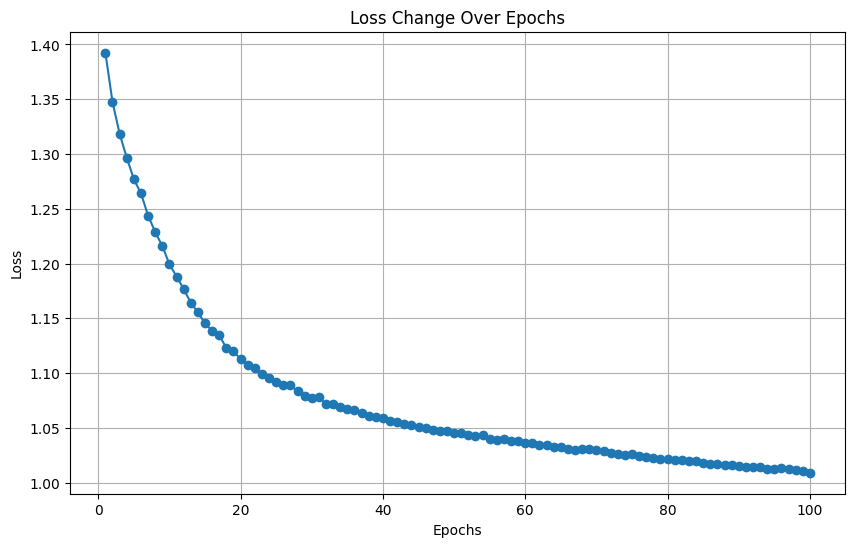

In [11]:
device = torch.device("cuda" if (torch.cuda.is_available() and cuda) else "cpu")

net = RSNN_direction()
criterion = nn.CrossEntropyLoss()
for param in net.l1.parameters():
    param.requires_grad = False
for param in net.rlif1.parameters():
    param.requires_grad = False
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad, net.parameters()), lr=0.01)
num_timesteps = 100
num_epochs = 100

epoch_losses = []
input_grad = []
rec_grad =[]
output_grad =[]
for epoch in range(num_epochs):
    epoch_loss = 0
    for i, (inputs, direction_labels) in enumerate(train_dataloader):
        inputs, direction_labels = inputs.to(device), direction_labels.to(device)
        optimizer.zero_grad()
        # Initialize tensors to store intermediate values
        outputs = []
        # firing_rate_per_batch = []
        # criticality_per_batch = []
        # synchrony_per_batch = []

        for batch_idx, (input, direction_label) in enumerate(zip(inputs, direction_labels)):
            # print("Shape of input for current batch:", input.shape)  # Should be (num_timesteps, 16)
            output, spikes = net(input)
            outputs.append(output)

        #     firing_rate = torch.sum(spikes) / (num_timesteps * spikes.shape[1])
        #     firing_rate_per_batch.append(firing_rate)

        #     criticality = simple_branching_param(10, spikes)
        #     criticality_per_batch.append(criticality)

        #     synchrony_fano_factor = fano_factor(num_timesteps, spikes)
        #     synchrony_per_batch.append(synchrony_fano_factor)

        outputs = torch.stack(outputs)  # (batch_size, num_timesteps)
        # firing_rate_per_batch = torch.tensor(firing_rate_per_batch)
        # criticality_per_batch = torch.tensor(criticality_per_batch)
        # synchrony_per_batch = torch.tensor(synchrony_per_batch)

        direction_labels = direction_labels.long()

        # Calculate the loss
        loss = criterion(outputs, direction_labels)
        
        loss.backward()
        #  torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        # input_grad.append(net.l1.weight.grad.detach().cpu().numpy())
        # rec_grad.append(net.rlif1.recurrent.weight.grad.detach().cpu().numpy())
        output_grad.append(net.l2.weight.grad.detach().cpu().numpy())
        optimizer.step()
        epoch_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}], Loss: {loss.item():.4f}')

    epoch_loss /= len(train_dataloader)
    epoch_losses.append(epoch_loss)

print("Training completed")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
plt.title('Loss Change Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

#### 7. Plotting functions

In [ ]:
import seaborn as sns
def plot_heatmap(data, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(data, cmap="viridis", annot=False)
    plt.title(title)
    plt.xlabel('Neuron Index')
    plt.ylabel('Neuron Index')
    plt.show()

In [ ]:
# print input layer gradients
print(len(input_grad))
print(input_grad[359])
first_epoch = input_grad[1]
plot_heatmap(first_epoch,'Input gradient at the first epoch')
last_epoch = input_grad[359]
plot_heatmap(first_epoch, 'Input gradient at the last epoch')

0


IndexError: list index out of range

In [ ]:
# print recurrent layer gradient
first_epoch = rec_grad[1]
plot_heatmap(first_epoch,'Recurrent gradient at the first epoch')
last_epoch = rec_grad[299]
plot_heatmap(first_epoch, 'Recurrent gradient at the last epoch')

IndexError: list index out of range

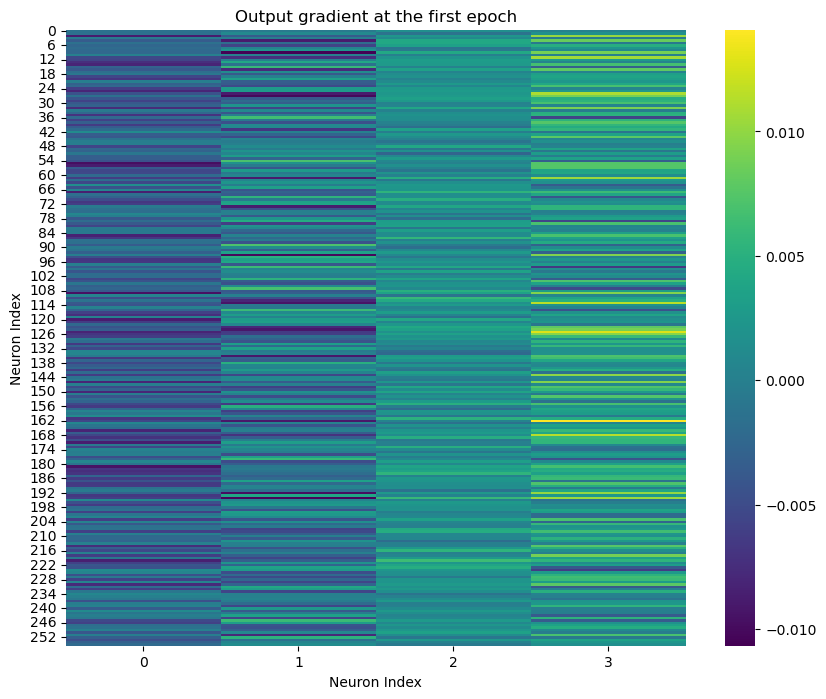

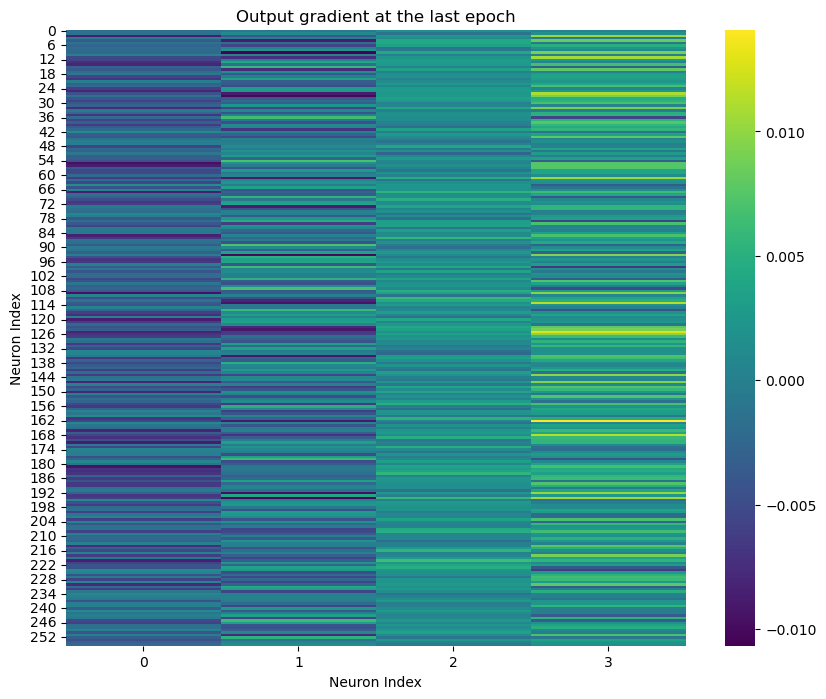

In [ ]:
first_epoch = output_grad[1].T
plot_heatmap(first_epoch,'Output gradient at the first epoch')
last_epoch = output_grad[299].T
plot_heatmap(first_epoch, 'Output gradient at the last epoch')

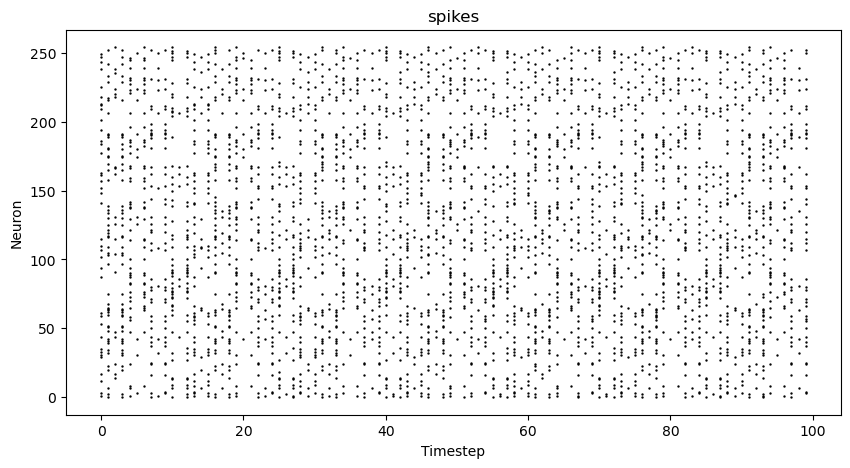

In [ ]:
# print(spikes)
plot_spike_tensor(spikes.T, "spikes")

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, direction_labels) in enumerate(dataloader):
            batch_size = inputs.size(0)
            outputs = []

            for input in inputs:
                output, _ = model(input)
                outputs.append(output)
            outputs = torch.stack(outputs)  # (batch_size, num_classes)

            # print(f"Batch {batch_idx+1} Outputs Shape: {outputs.shape}\n", outputs)

            predicted = outputs.argmax(dim=1)
            print(f"Batch {batch_idx+1} Predicted Labels: {predicted}")
            print(f"Batch {batch_idx+1} True Labels: {direction_labels}")
            total += direction_labels.size(0)
            correct += (predicted == direction_labels).sum().item()

    accuracy = correct/total
    return accuracy

test_accuracy = evaluate_model(net, test_dataloader)
print("Test Accuracy:", test_accuracy)


Batch 1 Predicted Labels: tensor([3, 0, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 3, 2, 1, 1, 0, 3, 0, 0, 0, 3, 2, 1,
        3, 2, 0, 2, 1, 3, 0, 1])
Batch 1 True Labels: tensor([3, 0, 2, 3, 3, 1, 0, 0, 0, 0, 0, 1, 3, 2, 1, 1, 0, 3, 1, 1, 1, 3, 3, 0,
        2, 2, 0, 3, 0, 1, 0, 2])
Batch 2 Predicted Labels: tensor([1, 0, 2, 3, 3, 0, 0, 1, 0, 3, 0, 1, 1, 2, 2, 3, 3, 2, 0, 0, 2, 0, 2, 1,
        3, 0, 2, 1, 2, 3, 3, 2])
Batch 2 True Labels: tensor([1, 0, 2, 3, 3, 3, 0, 3, 0, 3, 0, 1, 3, 2, 3, 3, 2, 3, 2, 0, 2, 3, 3, 1,
        3, 0, 2, 1, 2, 2, 3, 2])
Batch 3 Predicted Labels: tensor([0, 1, 2, 3, 0, 0, 3, 2])
Batch 3 True Labels: tensor([1, 1, 2, 3, 3, 0, 3, 2])
Test Accuracy: 0.6388888888888888


In [ ]:
net = RSNN_direction()
criterion = CustomLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.02)
num_epochs = 60

sparsity_list = []
num_timesteps = 100
weights = net.rlif1.recurrent.weight.data

loss_list = []
synch_list = []
rate_list = []
crit_list = []
c = 0

for epoch in range(num_epochs):
    mse_epoch_loss = 0
    rate_epoch_loss = 0
    synchrony_epoch_loss = 0
    criticality_epoch_loss = 0

    # # Initialize lists to hold data
    # batch_loss_list = []
    # mse_batch_loss_list = []
    # rate_batch_loss_list = []
    # synchrony_batch_loss_list = []
    # criticality_batch_loss_list = []
    # spikes_list = []
    # input_weights_list = []
    # rec_weights_list = []
    # output_weights_list = []
    # inputs_list = []
    # outputs_list = []
    # targets_list = []

    for i, (inputs, direction_labels) in enumerate(dataloader):
        optimizer.zero_grad()

        outputs = torch.empty((inputs.size(0), num_timesteps, 1), dtype=torch.float32, requires_grad=True)
        firing_rate_per_batch = []
        criticality_per_batch = []
        synchrony_per_batch = []

        for batch_idx, (input, direction_label) in enumerate(zip(inputs, direction_labels)):
            print("Shape of inputs:", inputs.shape)
            print("Shape of input for current batch:", input.shape)
            print("Shape of output from the model:", output.shape)
            print("Shape of spikes:", spikes.shape)
            print("Shape of direction_labels:", direction_labels.shape)

            output, spikes = net(input)
            spikes = spikes.T
            outputs[batch_idx] = output.unsqueeze(-1)


            if c == 0:
                net.naive_spikes = spikes
                c += 1

            firing_rate = torch.sum(spikes) / torch.tensor(100000, dtype=torch.int)
            firing_rate_per_batch.append(firing_rate)

            criticality = simple_branching_param(1, spikes)
            criticality_per_batch.append(criticality)

            synchrony_fano_factor = fano_factor(num_timesteps, spikes)
            synchrony_per_batch.append(synchrony_fano_factor)

        firing_rate_per_batch = torch.tensor(firing_rate_per_batch)
        criticality_per_batch = torch.tensor(criticality_per_batch)
        synchrony_per_batch = torch.tensor(synchrony_per_batch)
        # Ensure the direction_labels are in the correct shape for loss calculation
        direction_labels = direction_labels.view(-1, 1).expand(-1, num_timesteps)

        loss = criterion(outputs, direction_labels.float(), criticality_per_batch, firing_rate_per_batch, synchrony_per_batch)
        loss.backward()
        optimizer.step()
        
        # batch_loss_list.append(loss.item())
        # mse_batch_loss_list.append(criterion.mse_loss.item())
        # rate_batch_loss_list.append(criterion.rate_loss.item())
        # synchrony_batch_loss_list.append(criterion.synchrony_loss.item())
        # criticality_batch_loss_list.append(criterion.criticality_loss.item())
        # spikes_list.append(spikes.detach().numpy())
        # input_weights_list.append(net.l1.weight.data.detach().numpy())
        # rec_weights_list.append(net.rlif1.recurrent.weight.data.detach().numpy())
        # output_weights_list.append(net.l2.weight.data.detach().numpy())
        # inputs_list.append(inputs.detach().numpy())
        # outputs_list.append(outputs.detach().numpy())
        # targets_list.append(direction_labels.detach().numpy())

        zero_idxs = torch.where(weights == 0, 1, 0)
        weights[zero_idxs == True] = 0
        sparsity = (weights.numel() - weights.count_nonzero()) / weights.numel()
        sparsity_list.append(sparsity)

        net.positive_negative_weights()

    # # Save accumulated data to an npz file
    # np.savez(f'data/epoch{epoch}.npz',
    #          batch_loss=np.array(batch_loss_list),
    #          mse_batch_loss=np.array(mse_batch_loss_list),
    #          rate_batch_loss=np.array(rate_batch_loss_list),
    #          synchrony_batch_loss=np.array(synchrony_batch_loss_list),
    #          criticality_batch_loss=np.array(criticality_batch_loss_list),
    #          spikes=np.array(spikes_list),
    #          input_weights=np.array(input_weights_list),
    #          rec_weights=np.array(rec_weights_list),
    #          output_weights=np.array(output_weights_list),
    #          inputs=np.array(inputs_list),
    #          outputs=np.array(outputs_list),
    #          targets=np.array(targets_list))

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


NameError: name 'dataloader' is not defined

In [ ]:
# print(firing_rate_per_batch)
# print(synchrony_per_batch)
# print(sparsity_list)

In [ ]:
# post_input_hidden_mx_np = net.l1.weight.data.numpy()
# # Convert the NumPy array to a pandas DataFrame
# df_input_hid_post = pd.DataFrame(post_input_hidden_mx_np)
# # Save the DataFrame to a CSV file
# df_input_hid_post.to_csv(os.path.join('weights', 'post_input_hid_weights.csv'), index=False)

# post_hidden_mx_np = net.rlif1.recurrent.weight.data.numpy()
# # Convert the NumPy array to a pandas DataFrame
# df_hid_post = pd.DataFrame(post_hidden_mx_np)
# # Save the DataFrame to a CSV file
# df_hid_post.to_csv(os.path.join('weights', 'post_hid_weights.csv'), index=False)

# post_hidden_out_mx_np = net.l2.weight.data.numpy()
# # Convert the NumPy array to a pandas DataFrame
# df_hid_out_post = pd.DataFrame(post_hidden_out_mx_np)
# # Save the DataFrame to a CSV file
# df_hid_out_post.to_csv(os.path.join('weights', 'post_hid_out_weights.csv'), index=False)


In [ ]:
# print(outputs.shape)
# print(targets.shape)
# print(inputs.shape)
# for i in range(10):
#     input = inputs[i]
#     target = targets[i]
#     # target = target.numpy()
#     output = outputs[i]
#     output = output.detach().numpy()

#     # Convert target tensor to numpy array
#     y_target = target.numpy()
#     x_target = np.arange(len(y_target))

#     # Get the corresponding output list
#     y_output = np.array(output)
#     x_output = np.arange(len(y_output))

#     # Plot target tensor
#     plt.scatter(x_target, y_target, label=f'Target {i+1}', alpha=0.6)

#     # Plot output list
#     plt.scatter(x_output, y_output, label=f'Output {i+1}', alpha=0.6)

#     # Set labels and title
#     plt.xlabel('Index')
#     plt.ylabel('Value')
#     plt.title(f'Input: {input[:10].flatten()}\n Output {output[:10].flatten()}\n Target {target[:10]}')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

In [ ]:
# #Network makes zero weights become non_zero
# rlif1_w= net.rlif1.recurrent.weight.data
# zero_elements = torch.eq(rlif1_w, 0).sum().item()

# print(f"Number of zero elements: {zero_elements}")
# print(f"Ratio zero/all: {zero_elements/10**6}")

In [ ]:
# spikes_torch = spikes

# netrowk_sync=fano_factor(100, spikes_torch)
# print("Synchronity:", netrowk_sync)

In [ ]:
# plot_spike_tensor(net.naive_spikes[:100,:], "exc_naive_spikes")
# plot_spike_tensor(spikes[:200,:], "exc_spikes")
# plot_spike_tensor(net.naive_spikes[800:,:], "inh_naive_spikes")
# plot_spike_tensor(spikes[:800,:], "inh_spikes")